# Typhoon and Stock Return

In this tutorial, we will investigate whether the stock market performs abnormally after a strong typhoon. We will make extensive use of the data-handling package ```pandas```, the statistical functions of ```scipy``` and the statistics package ```statsmodel```.

## A. Data Cleaning

### A1. Typhoon data

The typhoon data is obtained from the Hong Kong Observatory. 
Each row contains data for a particular signal. Since typhoons often go through
several signals, there are multiple rows for each typhoon.

We will first do some preprocessing:
- Since we are only interested in the effect of strong typhoons, we will only keep typhoons that have a maximum signal at or above No. 8. 
- We will also keep record of the date each typhoon went below Signal No. 8.

A few notable pandas techniques that we will be using:
- To **select rows** out of a DataFrame whenever a certain column satisfying an inequality, use
```python
DataFrame[DataFrame['column_name'] >= value]
```
More generally, you can select rows by supplying a list of True/False values.


- To convert a column to pandas **datatime** format, use ```pd.to_datetime()```.
  You can then extract individual date components by ```.dt.year```, ```.dt.month``` etc.
  For example, to extract year out of a column called *date*, you can write:
  ```python
  DataFrame('date') = pd.to_datetime(DataFrame('date'))
  DataFrame('year') = DataFrame('date').dt.year 
  ```


- There are two ways to calculate the summary statistic of column B **grouped by** values of column A:
    - To collapse to one row per group, use:
        ```python
        DataFrame.groupby('column_A')['column_B'].ops()
        ```
        where `opts()` can be operations such as `mean()`, `max()`, etc. 
        Note that this method returns a pandas Series instead of a DataFrame. 
        To get a DataFrame, append `.to_frame()` at the end.
    - If you want to maintain the original number of rows, use:
        ```python
        DataFrame.groupby('column_A')['column_B'].transform('ops')
        ```

- To **drop duplicates**, use
```python
DataFrame.drop_duplicates(subset,keep)
```
    - `subset`: by default pandas consider two rows to be duplicates only 
    if they are identical for all columns. You can specify a narrower set of columns here. 

In [1]:
import pandas as pd

# Import data and keep only signal 8 or above
typhoon_data = pd.read_excel("../Data/typhoon_hk.xlsx")
typhoon_data = typhoon_data[typhoon_data["Signal"]>=8]

# Convert date to pandas datatime format and extract year
typhoon_data["end_date"] = pd.to_datetime(typhoon_data["end_date"])
typhoon_data['year'] = typhoon_data['end_date'].dt.year

# Find the highest signal for each typhoon and store it in 'Signal_max'
typhoon_data['Signal_max'] = typhoon_data.groupby(['Name','year'])['Signal'].transform('max')

# Keep only the last date for each typhoon
typhoon_data = typhoon_data.drop_duplicates(subset=['Name','year'],keep="last")

# Keep only three variables
typhoon_data = typhoon_data[["Name","Signal_max","end_date"]]

# Show the data
typhoon_data

,Name,Signal_max,end_date
2,LEO,8,1999-05-02
8,MAGGIE,9,1999-06-07
17,SAM,8,1999-08-23
25,YORK,10,1999-09-16
30,CAM,8,1999-09-26
52,UTOR,8,2001-07-06
57,YUTU,8,2001-07-25
66,HAGUPIT,8,2002-09-12
72,IMBUDO,8,2003-07-24
80,DUJUAN,9,2003-09-03


### A2. Stock data

For stock data, we will calculate the return from the previous trading day.

The most notable pandas technique we use here is ```.shift(x)```. 
This method shifts all rows down by *x* rows.
The nice thing about this technique is that you can totally do things
like 
```python
stock_data["Price"]/stock_data.shift(1)["Price"] - 1
```
which gives you all daily return in one single line.

Other notable techniques:
- **Drop rows with missing values**
```python
DataFrame.dropna()
```
- **Convert column(s) to numeric format**
```python
pd.to_numeric(DataFrame[['column_name']])
```
Specify `errors='coerce'` to force convert. Any values that is not numeric
will be converted to `NaN`.


- **Fill in missing dates**: first change the DataFrame's index to a date variable:
```python
DataFrame.index = pd.DatetimeIndex(DataFrame['date_column'])
```
Then
```python
DataFrame.asfreq(freq)
```

In [2]:
# Import stock data and keep only two variables
stock_data = pd.read_csv("../Data/hsi.csv")
stock_data = stock_data[["Date","Adj Close"]]

# Convert date to pandas datetime format
stock_data["Date"] = pd.to_datetime(stock_data["Date"])

# Adj Close is NaN on some dates. 
# Force convert everything to numeric and drop missing.
stock_data["Adj Close"] = pd.to_numeric(stock_data["Adj Close"],
                                        errors='coerce')
stock_data = stock_data.dropna()

# Calculate return since the previous trading day
stock_data["daily_return"] = (stock_data["Adj Close"] / 
                              stock_data.shift(1)["Adj Close"]
                              - 1)
# 90-day future return
stock_data["90d_return"] = (stock_data.shift(-90)["Adj Close"] / 
                              stock_data["Adj Close"]
                              - 1)

# Use date as the index of the dataframe and fill in missing dates
stock_data.index = pd.DatetimeIndex(stock_data["Date"])
stock_data = stock_data.asfreq(freq='D')

# Show the data
stock_data[0:10]

,Date,Adj Close,daily_return,90d_return
Date,,,,
1999-01-04,1999-01-04,9809.169922,NaN,0.287275
1999-01-05,1999-01-05,9891.059570,0.008348,0.253975
1999-01-06,1999-01-06,10233.799805,0.034652,0.209269
1999-01-07,1999-01-07,10693.570313,0.044927,0.147619
1999-01-08,1999-01-08,10722.700195,0.002724,0.159863
1999-01-09,NaT,NaN,NaN,NaN
1999-01-10,NaT,NaN,NaN,NaN
1999-01-11,1999-01-11,10634.269531,-0.008247,0.161049
1999-01-12,1999-01-12,10711.559570,0.007268,0.158483


### A3. Merge stock and typhoon data

We can now merge the stock and typhoon data. To **merge** two DataFrames A and B, use
```python
DataFrame_A.merge(DataFrame_B, options)
```
common options include:
- `how`: whether the merge keeps all samples from the left DataFrame (A), 
the right DataFrame (B), a union of the two or intersection. 
Default is intersection, which means only samples that appear on both DataFrames
will be kept.
- `left_on` and `right_on`: the name of the columns used to match the two DataFrames.
- `left_index` and `right index`: use the DataFrame index instead of a column for the match.


In [3]:
merged_data = stock_data.merge(typhoon_data, how='right', left_index=True, right_on='end_date')
merged_data

,Date,Adj Close,daily_return,90d_return,Name,Signal_max,end_date
2,NaT,NaN,NaN,NaN,LEO,8,1999-05-02
8,1999-06-07,12837.389648,0.033978,-0.041933,MAGGIE,9,1999-06-07
17,1999-08-23,13573.660156,0.000510,0.279657,SAM,8,1999-08-23
25,NaT,NaN,NaN,NaN,YORK,10,1999-09-16
30,NaT,NaN,NaN,NaN,CAM,8,1999-09-26
52,NaT,NaN,NaN,NaN,UTOR,8,2001-07-06
57,NaT,NaN,NaN,NaN,YUTU,8,2001-07-25
66,2002-09-12,9896.330078,0.001415,-0.031489,HAGUPIT,8,2002-09-12
72,2003-07-24,9923.139648,0.002281,0.255348,IMBUDO,8,2003-07-24
80,2003-09-03,11102.360352,0.014847,0.199824,DUJUAN,9,2003-09-03


Unless the typhoon's signal went below No. 8 before market opens, no stock data will be available for the given `end_date`. In this case we use the return from the next trading day.

First we extract the list of such typhoons. We can do that by using the ```.isnull()``` method:

In [4]:
merged_data_na = merged_data[merged_data['Adj Close'].isnull()]
merged_data_na = merged_data_na[["Name","Signal_max","end_date"]]
merged_data_na

,Name,Signal_max,end_date
2,LEO,8,1999-05-02
25,YORK,10,1999-09-16
30,CAM,8,1999-09-26
52,UTOR,8,2001-07-06
57,YUTU,8,2001-07-25
126,KAMMURI,8,2008-08-06
133,NURI,9,2008-08-23
152,MOLAVE,9,2009-07-19
190,NESAT,8,2011-09-29
201,DOKSURI,8,2012-06-30


Then we merge in stock information from the next day:

In [5]:
part2 = stock_data.tshift(-1).merge(merged_data_na, how='right', 
                                    left_index=True, right_on='end_date')
part2

,Date,Adj Close,daily_return,90d_return,Name,Signal_max,end_date
2,1999-05-03,13337.070313,0.000290,0.001467,LEO,8,1999-05-02
25,1999-09-17,13484.839844,0.004039,0.180423,YORK,10,1999-09-16
30,1999-09-27,12760.459961,-0.020842,0.271798,CAM,8,1999-09-26
52,NaT,NaN,NaN,NaN,UTOR,8,2001-07-06
57,2001-07-26,12039.820313,-0.014269,-0.073479,YUTU,8,2001-07-25
126,2008-08-07,22104.199219,0.007036,-0.315505,KAMMURI,8,2008-08-06
133,NaT,NaN,NaN,NaN,NURI,9,2008-08-23
152,2009-07-20,19502.369141,0.037048,0.159439,MOLAVE,9,2009-07-19
190,2011-09-30,17592.410156,-0.023244,0.189026,NESAT,8,2011-09-29
201,NaT,NaN,NaN,NaN,DOKSURI,8,2012-06-30


If return is still missing after this step, it must be the case that at least two days have passed since Signal No. 8 was lowered. We will ignore such instances.

To append one DataFrame at the bottom of another, use ```.append()```:

In [6]:
part1 = merged_data[merged_data['Adj Close'].notnull()]
part2 = part2.dropna()

# Final data
data_w_typhoon = part1.append(part2)
data_w_typhoon

,Date,Adj Close,daily_return,90d_return,Name,Signal_max,end_date
8,1999-06-07,12837.389648,0.033978,-0.041933,MAGGIE,9,1999-06-07
17,1999-08-23,13573.660156,0.000510,0.279657,SAM,8,1999-08-23
66,2002-09-12,9896.330078,0.001415,-0.031489,HAGUPIT,8,2002-09-12
72,2003-07-24,9923.139648,0.002281,0.255348,IMBUDO,8,2003-07-24
80,2003-09-03,11102.360352,0.014847,0.199824,DUJUAN,9,2003-09-03
87,2004-07-16,12059.200195,0.010033,0.160692,KOMPASU,8,2004-07-16
111,2007-08-10,21792.710938,-0.028818,0.240289,PABUK,8,2007-08-10
121,2008-06-25,22635.160156,0.007977,-0.344376,FENGSHEN,8,2008-06-25
139,2008-09-24,18961.990234,0.004723,-0.273860,HAGUPIT,8,2008-09-24
157,2009-08-05,20494.769531,-0.014505,0.068668,GONI,8,2009-08-05


## B. Statistical Analysis

Finally we can perform some statistical analysis. We will start with comparing the daily return on the first trading day after a typhoon versus all other days.

### B1. Statistical Tests

```scipy.stats``` contains many of the common tests. Noteable ones include:
- **T-test**: ```ttest_ind(A,B)```.
- **Median Test**: ```median_test(A,B)```. 
- **Mann-Whitney rank test**: ```mannwhitneyu(A,B)```. A non-parametric test on whether A and B have the same distribution.

In [7]:
from scipy import stats

# Stock data without typhoon. '~' means 'not'.
data_wo_typhoon = stock_data[~stock_data['Date'].isin(data_w_typhoon['Date'])].dropna()

# Mean daily returns
print("Daily return after typhoon:",data_w_typhoon['daily_return'].mean())
print("Daily return w/o typhoon:  ",data_wo_typhoon['daily_return'].mean())

print("-"*70)
print("Statistical Tests:      (statistic, p-value)")

# T-test
print("T-test:                ",stats.ttest_ind(data_w_typhoon['daily_return'],
                data_wo_typhoon['daily_return'])[0:2])

# Mood's median test
print("Mood's median test:    ",stats.median_test(data_w_typhoon['daily_return'],
                data_wo_typhoon['daily_return'])[0:2])

# Mann-Whitney test
print("Mann-Whitney rank test:",stats.mannwhitneyu(data_w_typhoon['daily_return'],
                data_wo_typhoon['daily_return'])[0:2])


Daily return after typhoon: 0.0011086837801795402
Daily return w/o typhoon:   0.00030950678282767164
----------------------------------------------------------------------
Statistical Tests:      (statistic, p-value)
T-test:                 (0.29787470527592164, 0.7658113998785598)
Mood's median test:     (0.13067290126128978, 0.7177353696347386)
Mann-Whitney rank test: (74545.0, 0.4446907115544794)


Turns out the stock market on average performs better right after a typhoon! The difference is not statistically significant though.

### B2. Regression

We can also run a regression. Note that running a regression with a single dummy variable is identical to running a T-test:

In [8]:
# Signal max = 0 if no typhoon
data_wo_typhoon['Signal_max'] = 0
data_whole = data_w_typhoon.append(data_wo_typhoon)

# Convert Signal_max to a dummy variable called 'typhoon'
data_whole["typhoon"] = 0
data_whole.loc[data_whole['Signal_max']>=8,'typhoon'] = 1

# scipy OLS
stats.linregress(data_whole['typhoon'],data_whole['daily_return'])

LinregressResult(slope=0.000799176997351875, intercept=0.0003095067828276718, rvalue=0.004251411908941538, pvalue=0.7658113998785584, stderr=0.00268293004809385)

If you prefer output that is more in line with what a statistical package like Stata would give you, use ```statsmodels``` instead:

In [9]:
# statsmodel OLS
import statsmodels.api as sm

# statsmodel does not add the constant by default, so add manually
results = sm.OLS(data_whole['daily_return'],
                 sm.add_constant(data_whole['typhoon'])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08873
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.766
Time:                        13:04:39   Log-Likelihood:                 13693.
No. Observations:                4911   AIC:                        -2.738e+04
Df Residuals:                    4909   BIC:                        -2.737e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.452      0.147      -0.000       0.001
typhoon        0.0008      0.003      0.298      0.766      -0.004       0.006
==============================================================================
Omnibus:                      755.636   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12263.021
Skew:                           0.133   Prob(JB):                         0.00
Kurtosis:                      10.737   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As as a statistical package, ```statsmodels``` have many of the common procedures built in. For example, we can correct for serial correlation by computing the Newey-West Standard Errors:

In [10]:
# Newey-West Standard Errors. Note that we are using the results
# from the previous regression.
nw = results.get_robustcov_results(cov_type='HAC',maxlags=5)
nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1540
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.695
Time:                        13:04:39   Log-Likelihood:                 13693.
No. Observations:                4911   AIC:                        -2.738e+04
Df Residuals:                    4909   BIC:                        -2.737e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.482      0.139      -0.000       0.001
typhoon        0.0008      0.002      0.392      0.695      -0.003       0.005
==============================================================================
Omnibus:                      755.636   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12263.021
Skew:                           0.133   Prob(JB):                         0.00
Kurtosis:                      10.737   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

Here is another idea: what about buying HSI right after a typhoon? Let us compare the mean return of buying right after a typhoon versus that of other days. We will assume a fixed 90-day holding period.

In [11]:
# If you want Newey-West standard errors to begin with, this is how:
results = sm.OLS(data_whole['90d_return'],
              sm.add_constant(data_whole['typhoon'])
             ).fit(cov_type='HAC',cov_kwds={'maxlags':5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             90d_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.322
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.250
Time:                        13:04:39   Log-Likelihood:                 2659.1
No. Observations:                4911   AIC:                            -5314.
Df Residuals:                    4909   BIC:                            -5301.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0269      0.005      5.510      0.000       0.017       0.036
typhoon        0.0263      0.023      1.150      0.250      -0.019       0.071
==============================================================================
Omnibus:                      195.088   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.655
Skew:                           0.214   Prob(JB):                    3.81e-103
Kurtosis:                       4.457   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

Buying after typhoon gives us on average a 2.6% higher return over 3 months! To bad it is not statistically significant.

## C. That's It? No Significant Result?

Let us plot the distribution of returns for days with typhoon and without:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc67eb4ed60>,
      dtype=object)

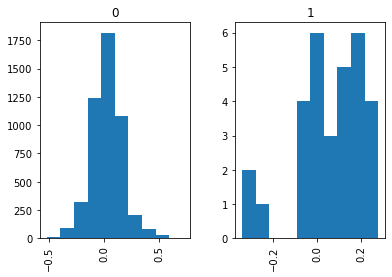

In [12]:
%matplotlib inline
data_whole.hist(column='90d_return',by='typhoon')  

It does look like return is higher after a typhoon. Thinking about it, a Signal 8 typhoon is often quite predestrian---people actually go out for breakfast and movies. What if we focus only on the strongest typhoons? I leave this as an exercise for you.